In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Chemin vers le dossier dataset dans Google Drive
data_dir = '/content/drive/MyDrive/pfa/pre_dataset'

# Afficher la liste des fichiers dans le dossier dataset
files = os.listdir(data_dir)
print(files)

['Te-gl_0243.jpg', 'Te-me_0298.jpg', 'training', 'Testing']


In [ ]:
#Miscellaneous
import os
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

#For data manipulation
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image, ImageEnhance

#For neural network
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

In [ ]:
#Load Training Data
train_data_dir = '/content/drive/MyDrive/pfa/pre_dataset/training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

#Concatenate data paths
Fseries = pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels, name = 'labels')

train_df = pd.concat([Fseries, Lseries], axis = 1)

In [ ]:
#Load Testing Data
test_data_dir = '/content/drive/MyDrive/pfa/pre_dataset/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

#Concatenate data paths
Fseries = pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels, name ='labels')

ts_df = pd.concat([Fseries, Lseries], axis = 1)

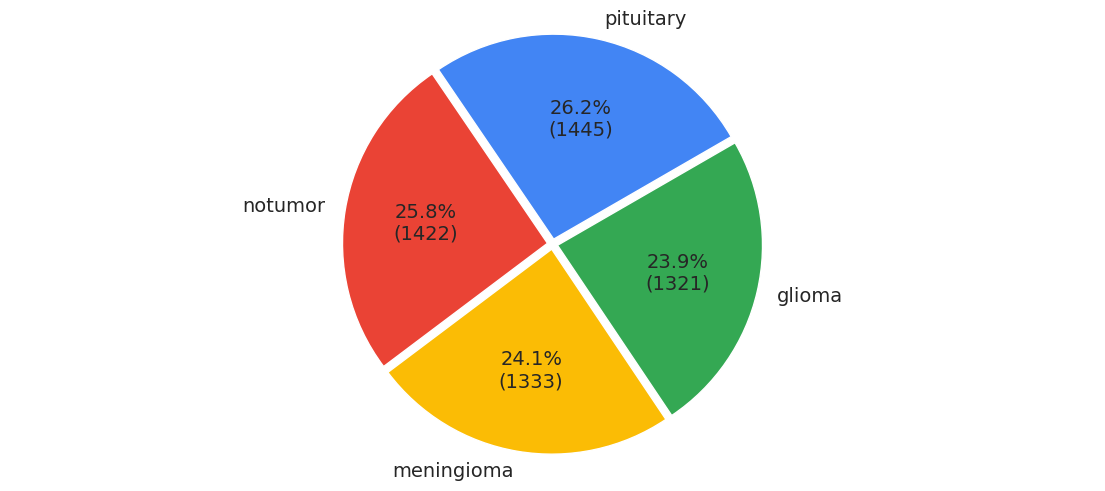

In [ ]:
#Graph Dataset Split
plt.figure(figsize = (14, 6))
plt.rcParams.update({'font.size': 14})
data_balance = train_df.labels.value_counts()

def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct * total / 100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

plt.pie(data_balance,
        labels = data_balance.index,
        autopct = custom_autopct,
        colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853'],
        explode = (0.025, 0.025, 0.025, 0.025),
        startangle = 30);
plt.axis('equal')
plt.show()

In [ ]:
#Split dataset
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [ ]:
#Augment and Preprocess Scans
batch_size = 32
img_size = (240, 240)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
                                    color_mode = 'rgb', shuffle = True, batch_size = batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
                                    color_mode = 'rgb', shuffle = True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
                                    color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 5521 validated image filenames belonging to 4 classes.
Found 642 validated image filenames belonging to 4 classes.
Found 642 validated image filenames belonging to 4 classes.


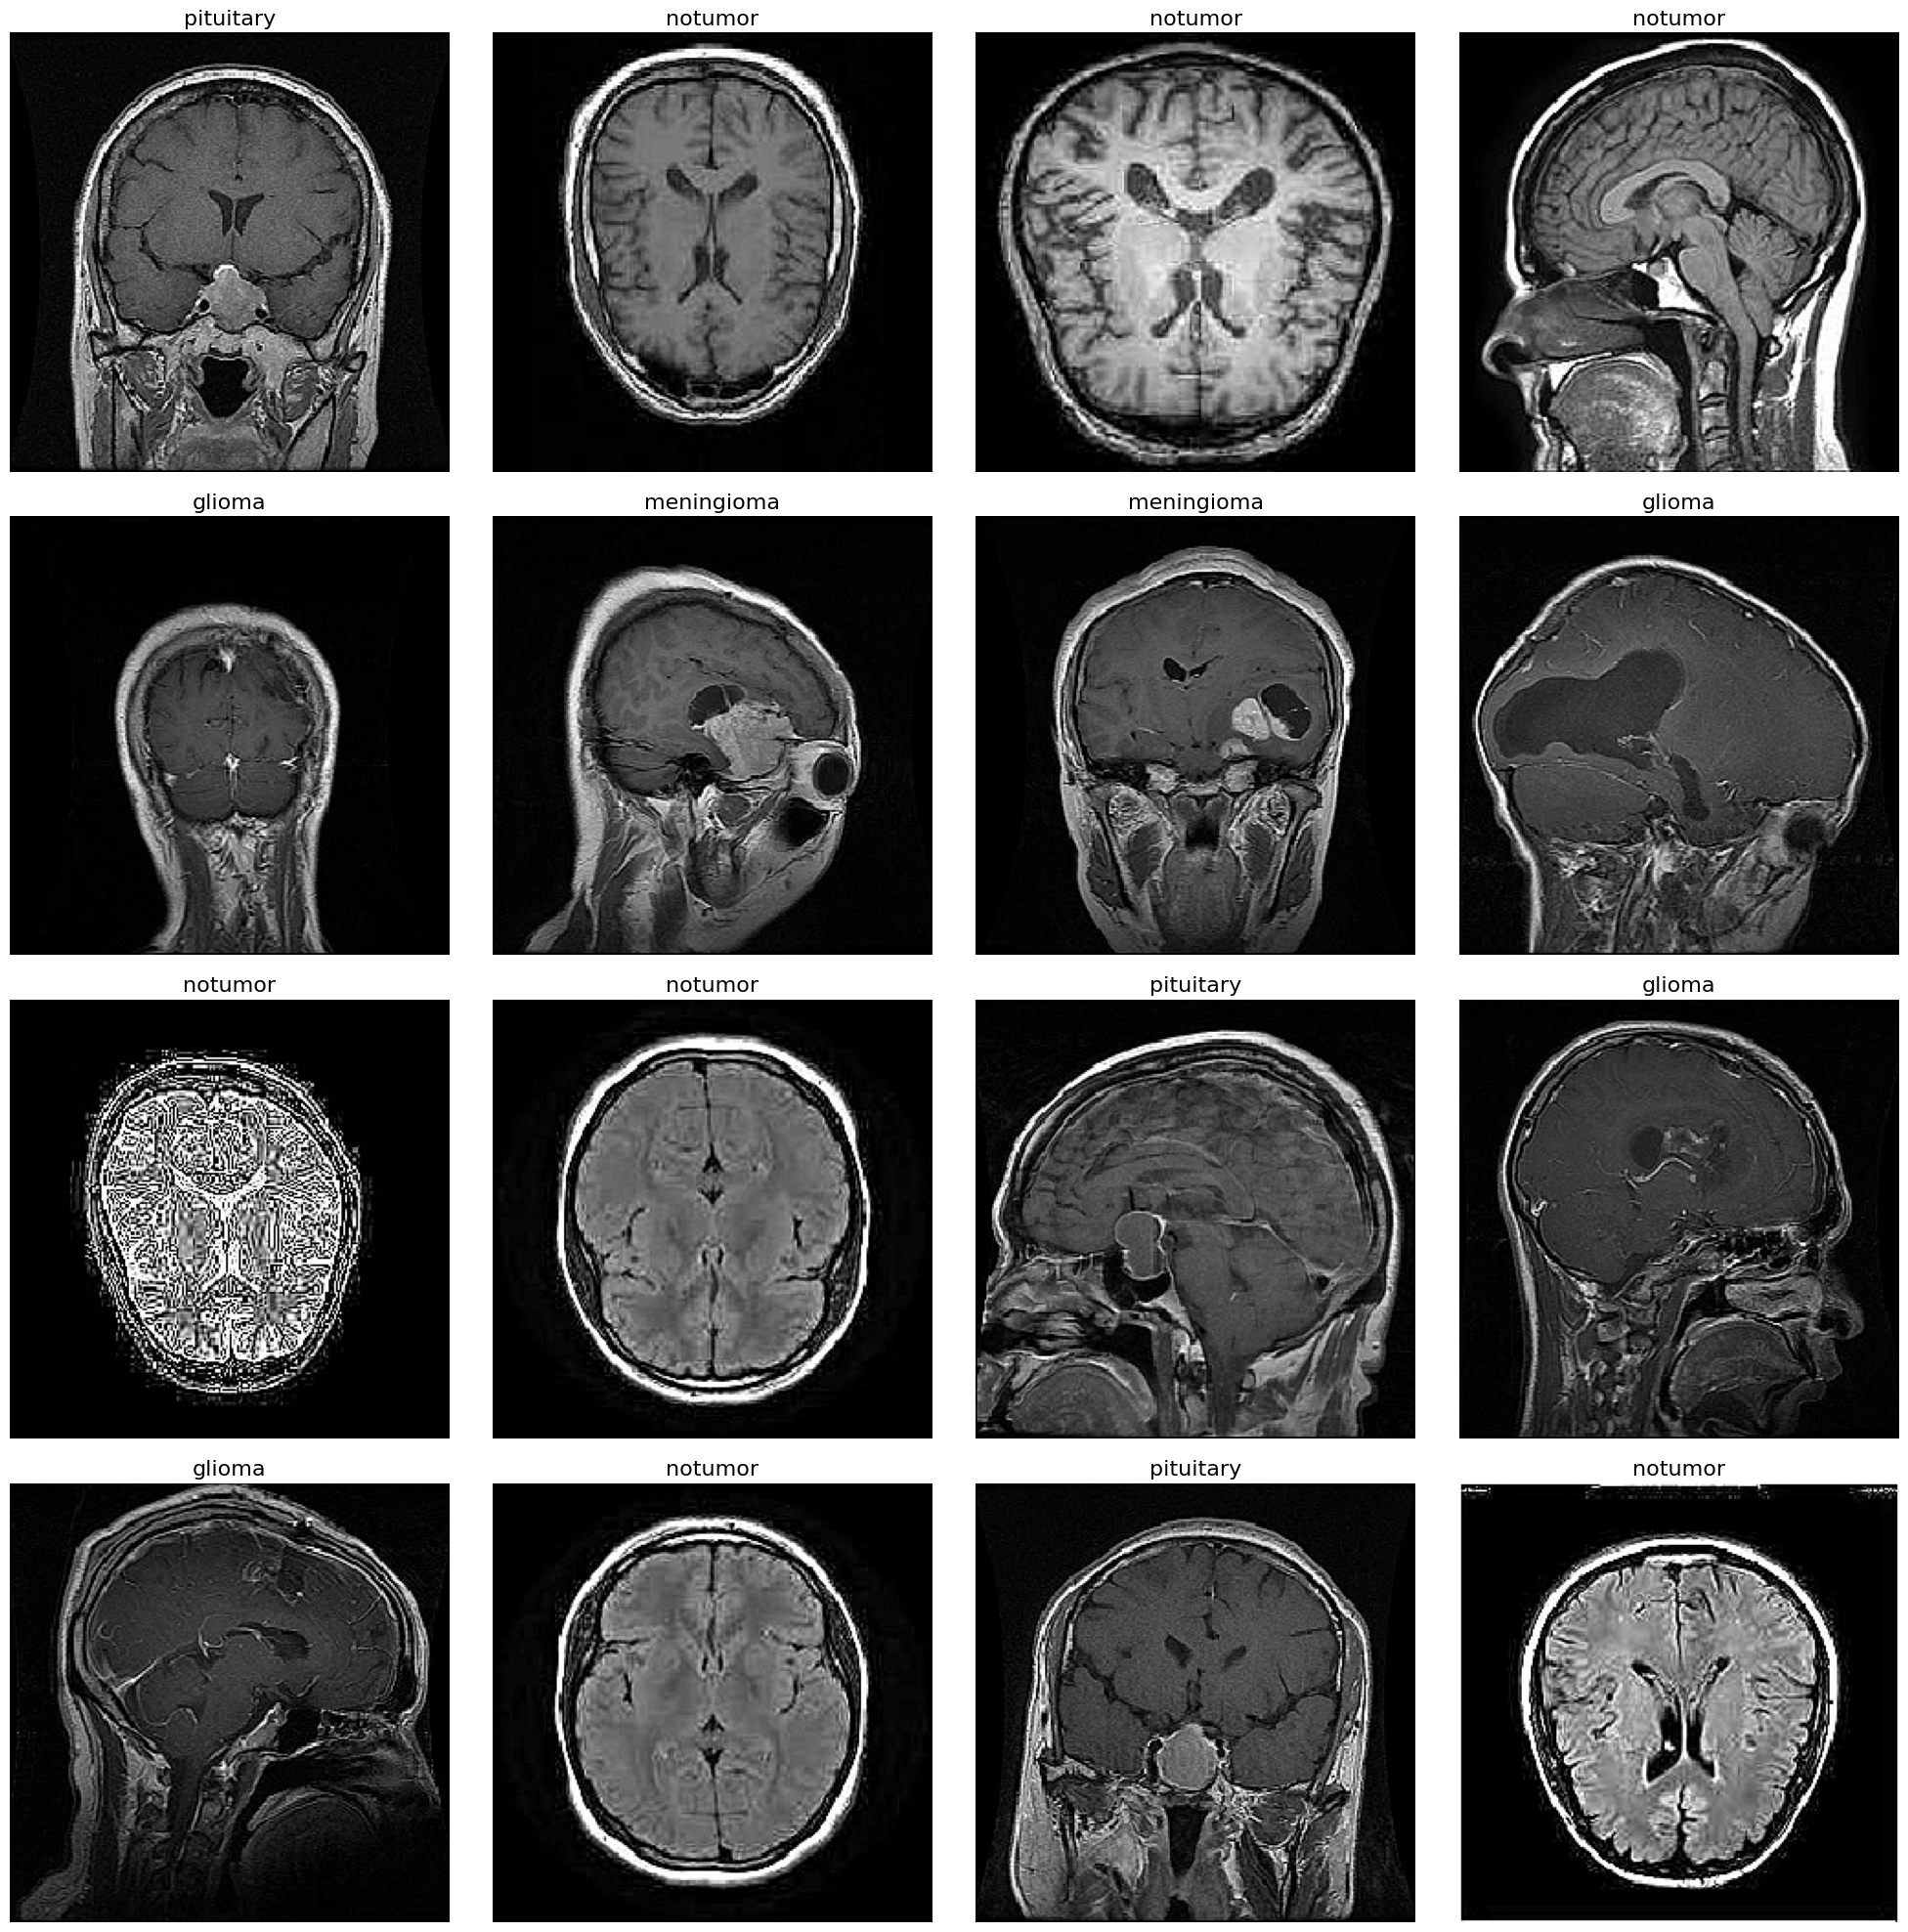

In [ ]:
#Plot Processed Scans
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize = (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color = 'black', fontsize = 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

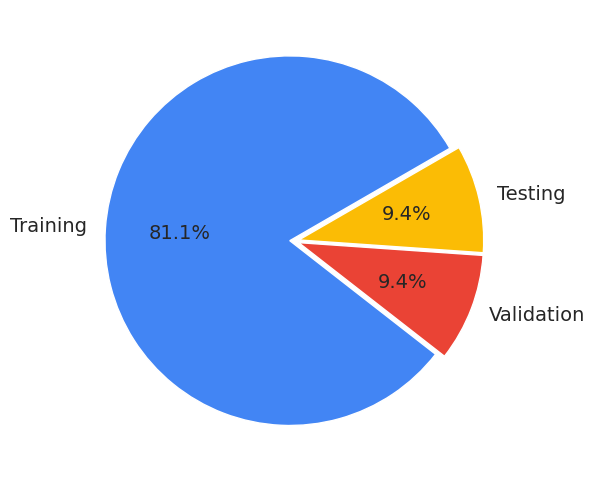

In [ ]:
#Graph Dataset Directories
plt.figure(figsize = (14, 6))
plt.rcParams.update({'font.size': 14})

plt.pie([len(train_df), len(valid_df), len(test_df)],
        labels = ['Training','Validation', 'Testing'],
        colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853'],
        autopct = '%.1f%%',
        explode = (0.025, 0.025, 0.025),
        startangle = 30);

In [ ]:
#Create model architecture
img_size = 240
class_count = len(list(train_gen.class_indices.keys()))

base_model = VGG19(input_shape = (img_size, img_size, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()

model.add(Input(shape = (img_size, img_size, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(class_count, activation = 'softmax'))

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 23236292 (88.64 MB)
Trainable params: 1029

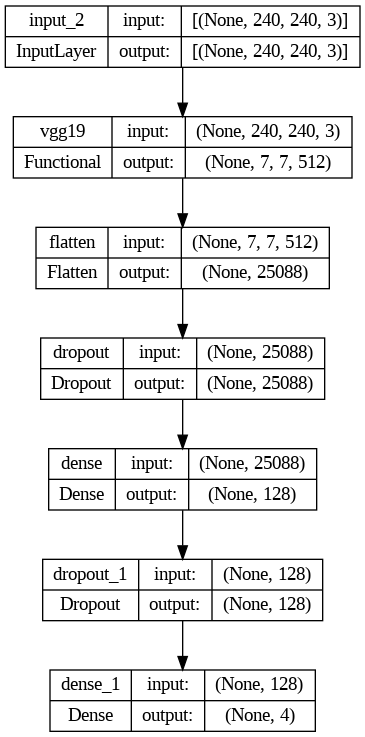

In [ ]:
keras.utils.plot_model(model, show_shapes = True)

In [ ]:
#LETS GO! NO ERRORS! Time to compile
model.compile(optimizer = Adam(learning_rate = 0.0001),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

batch_size = 32
epochs = 20
history = model.fit(train_gen,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = valid_gen,
                    shuffle = False)

Epoch 1/20
173/173 [==============================] - 50s 277ms/step - loss: 0.0634 - accuracy: 0.9855 - val_loss: 0.1758 - val_accuracy: 0.9657
Epoch 2/20
173/173 [==============================] - 41s 234ms/step - loss: 0.0623 - accuracy: 0.9859 - val_loss: 0.1413 - val_accuracy: 0.9611
Epoch 3/20
173/173 [==============================] - 39s 227ms/step - loss: 0.0206 - accuracy: 0.9931 - val_loss: 0.1235 - val_accuracy: 0.9751
Epoch 4/20
173/173 [==============================] - 40s 228ms/step - loss: 0.0472 - accuracy: 0.9866 - val_loss: 0.1304 - val_accuracy: 0.9720
Epoch 5/20
173/173 [==============================] - 40s 228ms/step - loss: 0.0527 - accuracy: 0.9893 - val_loss: 0.1536 - val_accuracy: 0.9548
Epoch 6/20
173/173 [==============================] - 40s 229ms/step - loss: 0.0367 - accuracy: 0.9890 - val_loss: 0.1930 - val_accuracy: 0.9704
Epoch 7/20
173/173 [==============================] - 40s 229ms/step - loss: 0.0607 - accuracy: 0.9853 - val_loss: 0.1202 - val_ac

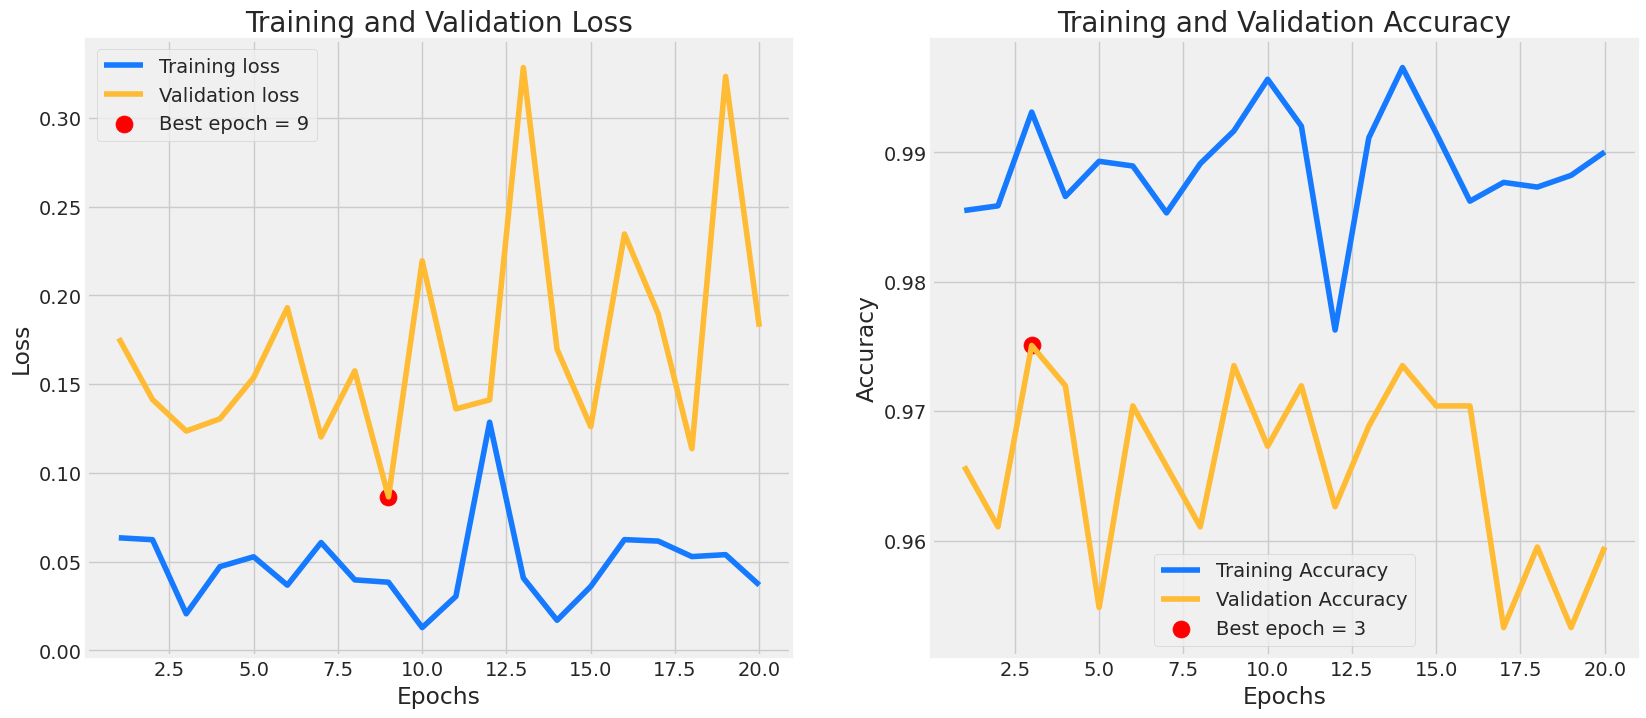

In [ ]:
#Graph results
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

plt.figure(figsize = (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, color = '#157AFF', label = 'Training loss')
plt.plot(Epochs, val_loss, color = '#FFBB33', label = 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s = 150, color = 'red', label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, color = '#157AFF', label = 'Training Accuracy')
plt.plot(Epochs, val_acc, color = '#FFBB33', label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s = 150, color = 'red', label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
#Results for training, validating, testing
train_score = model.evaluate(train_gen, verbose = 1)
valid_score = model.evaluate(valid_gen, verbose = 1)
test_score = model.evaluate(test_gen, verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

21/21 [==============================] - 203s 10s/step - loss: 0.2076 - accuracy: 0.9626
Train Loss:  0.046415336430072784
Train Accuracy:  0.9914870262145996
--------------------
Validation Loss:  0.18227072060108185
Validation Accuracy:  0.9595015645027161
--------------------
Test Loss:  0.20757469534873962
Test Accuracy:  0.9626168012619019


In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

21/21 [==============================] - 4s 166ms/step


In [ ]:
#new
def preprocess_image(image):
    img = Image.open(image)
    img = img.resize((224, 224))  # Resize image to match model input shape
    # img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img ,axis=0)  # Add batch dimension
    return img_array

In [ ]:
from PIL import Image
def preprocess_image(image):
    img = Image.open(image)
    img = img.resize((240, 240))  # Resize image to match model input shape
    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Exemple d'utilisation
# img_array = preprocess_image('path_to_your_image.jpg')
# predictions = model.predict(img_array)
# y_pred = np.argmax(predictions, axis=1)
# print("Prediction: ", y_pred)


In [ ]:
img5 = preprocess_image("/content/drive/MyDrive/pfa/pre_dataset/Testing/pituitary/Te-piTr_0006.jpg")

tested_img5 = model(img5)
y_pred5=np.argmax(tested_img5,axis=1)

print("pituitary , class index 3 ",y_pred5)

img7 = preprocess_image("/content/drive/MyDrive/pfa/pre_dataset/Testing/meningioma/Te-me_0024.jpg")

tested_img7 = model(img7)
y_pred7 =np.argmax(tested_img7,axis=1)

print("meningioma , class index 1 ",y_pred7)

img8 = preprocess_image("/content/drive/MyDrive/pfa/pre_dataset/Testing/glioma/Te-gl_0016.jpg")

tested_img8 = model(img8)
y_pred8=np.argmax(tested_img8,axis=1)

print( "glioma , class index 0 ", y_pred8 )

pituitary , class index 3  [0]
meningioma , class index 1  [0]
glioma , class index 0  [0]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Fonction pour afficher les prédictions sur un lot de données de test
def visualize_predictions(model, test_gen, class_names, num_images=20):
    plt.figure(figsize=(18, 18))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Ajuster les espaces entre les sous-graphiques

    # Obtenir un lot de données de test à l'aide de la méthode next
    images, labels = next(test_gen)

    # Obtenir les prédictions pour le lot de données de test
    predict_batch = model.predict(images)

    for i in range(min(len(images), num_images)):  # Parcourir les images jusqu'à un maximum de num_images
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i]/255.)  # Normaliser les pixels de l'image
        actual_label = class_names[np.argmax(labels[i])]  # Obtenir le nom de la classe réelle
        predicted_label = class_names[np.argmax(predict_batch[i])]  # Obtenir le nom de la classe prédite
        plt.title(f"Actual: {actual_label}\nPredected: {predicted_label}")
        plt.axis("off")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display predictions on a batch of test data
def visualize_predictions(model, test_gen, class_names, num_images=16): # Changed num_images to 16
    plt.figure(figsize=(18, 18))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust spaces between subplots

    # Get a batch of test data using the next method
    images, labels = next(test_gen)

    # Get the predictions for the batch of test data
    predict_batch = model.predict(images)

    for i in range(min(len(images), num_images)):  # Iterate through images up to a maximum of num_images
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i]/255.)  # Normalize image pixels
        actual_label = class_names[np.argmax(labels[i])]  # Get the name of the actual class
        predicted_label = class_names[np.argmax(predict_batch[i])]  # Get the name of the predicted class
        plt.title(f"Actual: {actual_label}\nPredected: {predicted_label}")
        plt.axis("off")

1/1 [==============================] - 0s 31ms/step


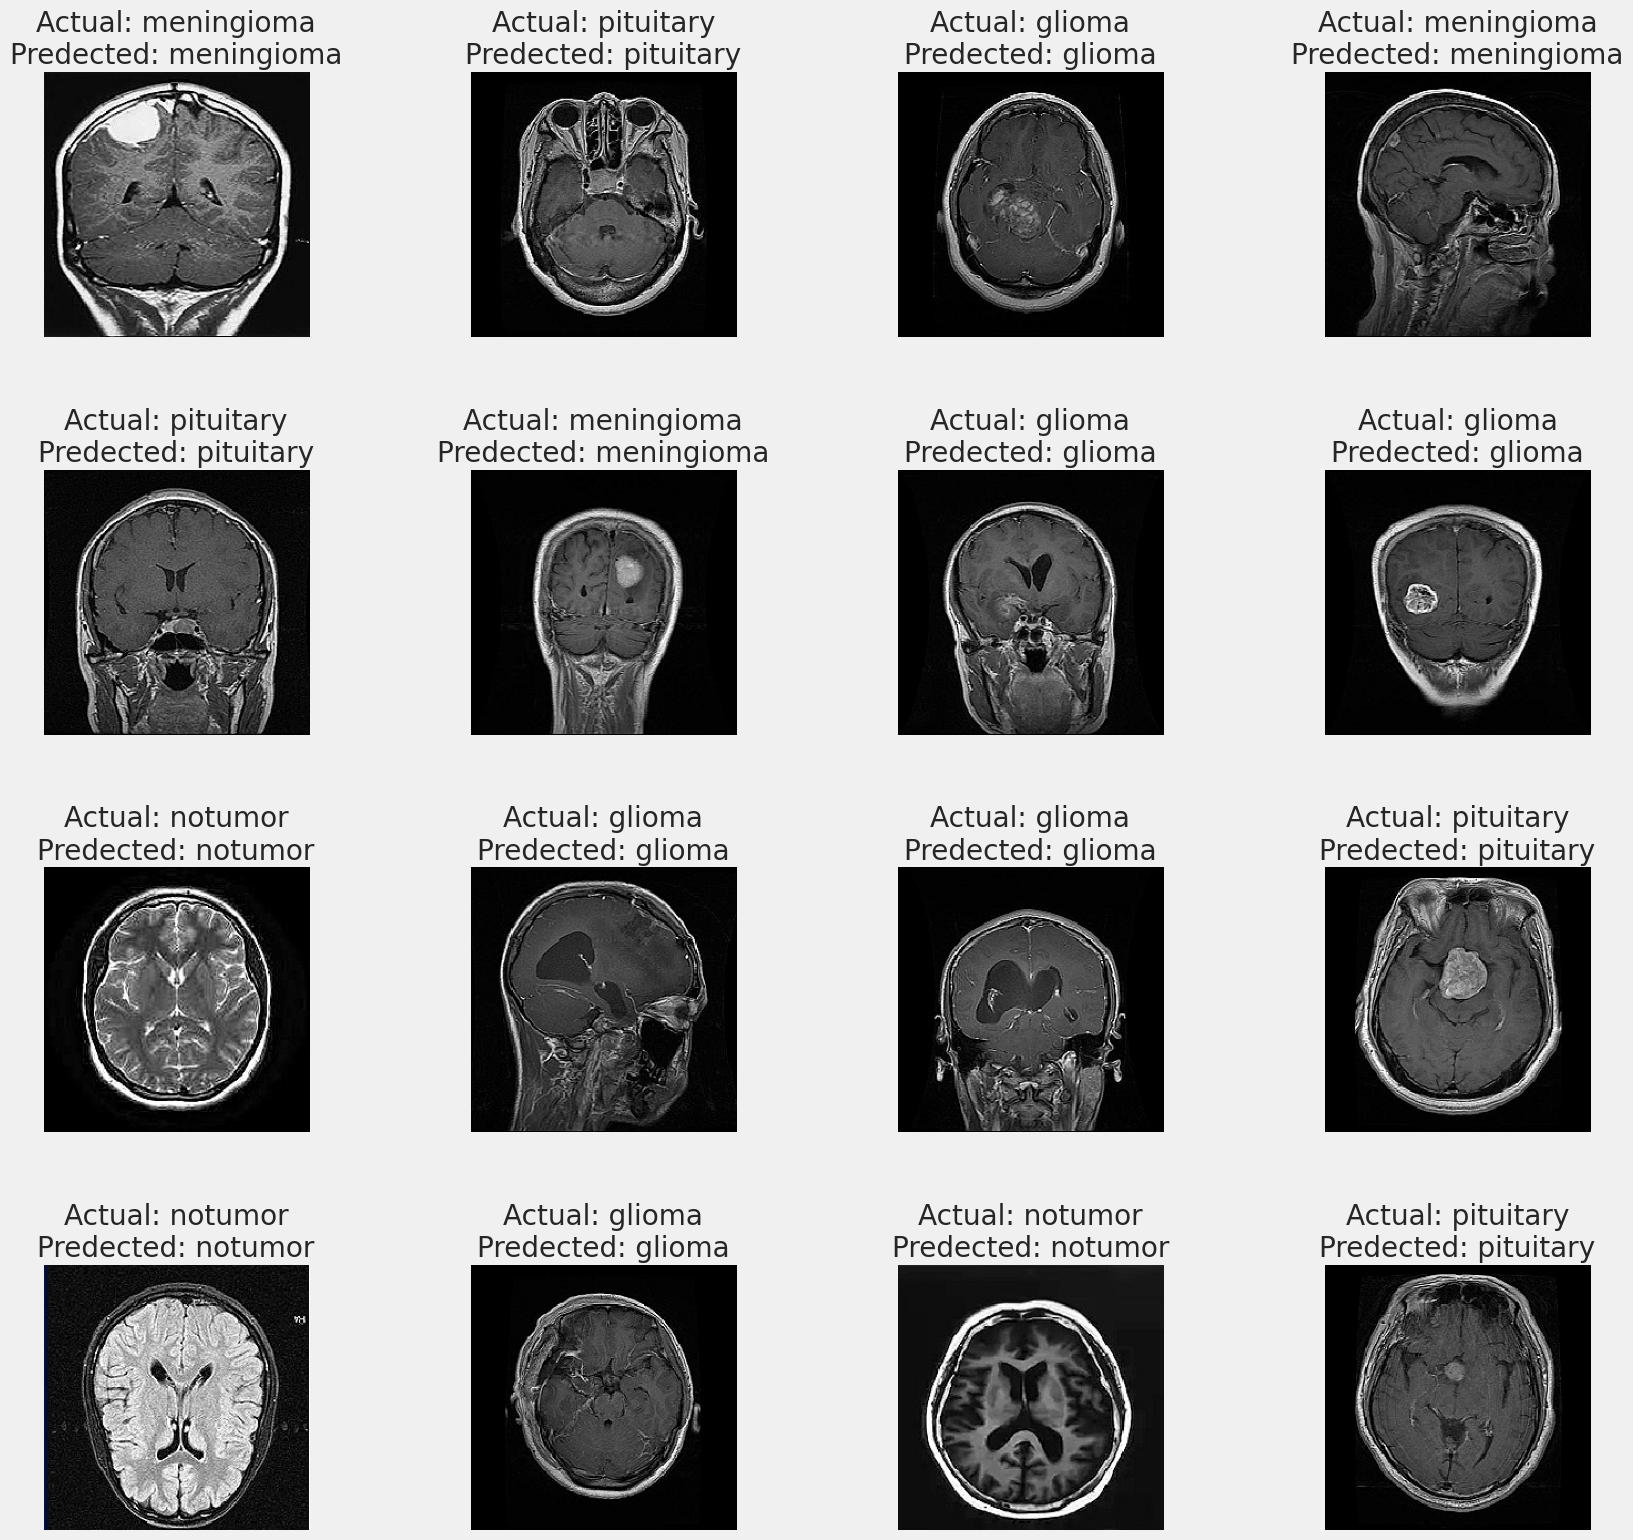

In [ ]:
# Liste des noms de classe
class_names = sorted(test_gen.class_indices.keys())  # Utilisez test_gen pour obtenir les noms de classe

# Afficher les prédictions pour un lot de données de test avec le modèle CNN
visualize_predictions( model, test_gen, class_names)

In [ ]:
# Évaluer le modèle sur le générateur de test
scores = model.evaluate(test_gen, verbose=0)

# Print the scores to see what metrics are available
print(scores)

# Initialiser la liste des résultats
results = []

# Définir le nombre d'époques (à ajuster en fonction de votre modèle)
epochs = 20

# Créer un dictionnaire pour stocker les résultats
# Adjust indices based on the available metrics printed above
result = {
    'Epochs': epochs,
    'Model': 'VGG19',  # Mettre à jour le nom du modèle
    'Loss': scores[0], # Assuming the first element is loss
    'Accuracy': f'{scores[1] * 100:.2f}%' # Assuming the second element is accuracy
    # Add other metrics as needed based on the printed scores
}

# Ajouter le dictionnaire à la liste des résultats
results.append(result)

# Créer le DataFrame Pandas
!pip install pandas
import pandas as pd
df = pd.DataFrame(results)

# Afficher le DataFrame
print(df)

[0.20757469534873962, 0.9626168012619019]


Epochs  Model      Loss Accuracy
0      20  VGG19  0.207575   96.26%

In [ ]:
#ennnnnnd

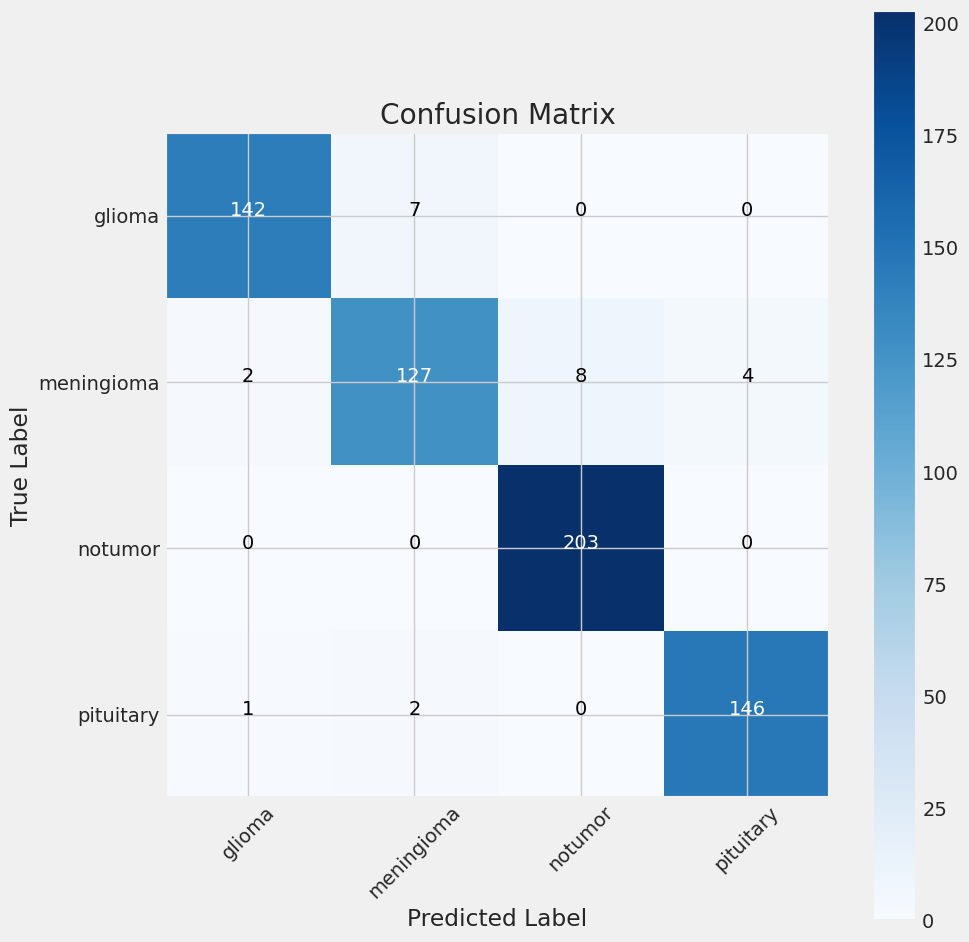

In [ ]:
#Confusion matrix
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize = (10, 10))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
#new
cr=classification_report(test_gen.classes,y_pred)
print(cr)

'              precision    recall  f1-score   support\n\n           0       0.98      0.95      0.97       149\n           1       0.93      0.90      0.92       141\n           2       0.96      1.00      0.98       203\n           3       0.97      0.98      0.98       149\n\n    accuracy                           0.96       642\n   macro avg       0.96      0.96      0.96       642\nweighted avg       0.96      0.96      0.96       642\n'

In [ ]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       0.98      0.95      0.97       149
  meningioma       0.93      0.90      0.92       141
     notumor       0.96      1.00      0.98       203
   pituitary       0.97      0.98      0.98       149

    accuracy                           0.96       642
   macro avg       0.96      0.96      0.96       642
weighted avg       0.96      0.96      0.96       642



In [ ]:
model_json = model.to_json()
with open("modele_architecture.json", "w") as json_file:
    json_file.write(model_json)


# serialize weights to HDF5
model.save("/content/drive/My Drive/pfa/Colab Notebooks/Vgg19_model2.h5")

In [ ]:
print('salam')

salam


In [ ]:
print('hello world')

hello world
